<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">


<img src="../Images/logo.png" alt="RetroChem Logo" style="max-width: 100%; height: auto;">

# **Introduction**

The following Jupyter notebook briefly presents **RetroChem**, a pip-installable Python package designed for retrosynthetic analysis. This package was developed to assist chemists and chemical engineers in predicting possible synthetic pathways for target molecules, using a machine learning model trained on the USPTO_50K database. Retrosynthesis is a central concept in organic chemistry, enabling the design of efficient synthetic routes by working backward from the desired product.

This package was created as a collaborative project for the EPFL course Practical Programming in Chemistry. [![GitHub3](https://img.shields.io/badge/EPFL-CH200-red.svg)](https://edu.epfl.ch/studyplan/en/bachelor/chemistry-and-chemical-engineering/coursebook/practical-programming-in-chemistry-CH-200)

Before diving into the code and functionalities of the package, let’s briefly explore the motivations and core concepts that shaped its development.

# **How Retrochem came to mind**

The idea for RetroChem emerged from our shared interest in organic synthesis and the growing importance of computational tools in modern chemistry. During our organic chemistry courses and laboratories we often encountered the challenge of synthesizing a target molecule from known reactants, a task that both requires extensive expertise in chemistry and is also very time consuming. 

At first, we envisioned RetroChem as a tool that would search through a large database of known reactions, both organic and inorganic, to identify possible transformations for a given target molecule. The idea was to use the most comprehensive reaction datasets available and search whether a synthesis existed for the molecule in question.

However, we quickly realized the scale of this task. The chemical universe is immensely large: it’s estimated there are up to 10⁶⁰ possible compounds. Even the most complete databases, such as CAS, which contains over 70 million registered compounds, are just a small fraction of that space. Searching such a large database for each input would not only be computationally intensive, potentially taking multiple minutes for even simple queries, but also fundamentally limited in scope.

This insight led us to turn toward **machine learning**. Instead of exhaustively searching for known reactions, we decided to train a model that could generalize from reaction data and predict retrosynthetic steps based on learned patterns. This approach allows RetroChem to make educated predictions even for molecules it has never seen before. 


# **Difficulties**

One of the main difficulties we encountered during the Retrochem project was that none of us had any prior experience with machine learning or the libraries typically used in that domain. A crucial early challenge was understanding what type of model we should train and, more importantly, what data we should use. Fortunately, the teaching assistants played a key role in guiding us: they helped us choose a suitable model for retrosynthesis prediction—specifically, the MLPClassifier from scikit-learn—and pointed us to the USPTO_50K dataset as a standard and appropriate resource for training. Once we had access to the data, we entered a long phase of trial and error where we tested different hyperparameters, layer sizes, and learning rates to optimize model performance. Through experimentation, we found that splitting the data into 70% training, 15% validation, and 15% test gave the most reliable and consistent results in terms of both accuracy and generalizability. 

The second issue we ran into was getting the saved model to produce meaningful retrosynthetic predictions. After training our model to predict reaction templates from molecular fingerprints, we initially expected it to directly output the correct set of reactants for a target molecule. However, we quickly realized that the model alone only predicted general reaction rules expressed as SMARTS strings and didn’t actually perform any chemical transformations. At first, we suspected the issue was with the model’s performance, but the missing piece was actually a way to apply these predicted templates to the input molecule in a chemically meaningful way. This problem was resolved by writing a function that used RDKit’s built-in reaction engine.
This engine is a tool that lets us simulate how molecules react by following general reaction rules written in a SMARTS format. These rules describe how certain parts of a molecule can be changed or broken apart. Using RDKit, we could load a SMARTS and try to apply it to our input molecule. If it successfully transformed the molecule and gave us possible reactants, we kept the result. If it didn’t work (for example, if the molecule didn’t contain the right part for the reaction), we discarded the SMARTS. This way, we only kept the reactions that actually made chemical sense for the molecule we were analyzing.

After that, the rest of the code was relatively straightforward, it mainly involved normalizing the prediction confidence scores and displaying the valid predictions in the Streamlit app.

The final issue we encountered was creating the pip-installable package. Our project relied on several interdependent folders and components—such as combined_data.csv, scaler, model, label, and the source code (Retrochem.py) which made it quite complex to structure the setup. Initially, we wanted to organize everything into separate folders: one for the data, one for the model, and one for the source code. However, we soon realized that for the PyPI export to work correctly, all components needed to be within a single main directory (RetroChem) to ensure proper packaging and imports. eleven versions later and much trial and error, we finally had a functional PyPI package that could be installed and run smoothly.

# **Step 1: Training the model**

### General Pipeline

* **Data Loading**: We began by loading three preprocessed datasets derived from **USPTO-50K**: training, validation, and test. Each file contains cleaned reaction SMILES strings representing the chemical transformations, along with their associated reaction templates. 

* **Data Merging**: The three datasets were merged into a single DataFrame and saved as **combined_data.csv**. To avoid redundant information, duplicate reactions were removed during this merging step in order to prevent data leakage. 

* **Fingerprint Generation**: Before a machine learning model can understand molecules, we need to convert them from their chemical structure (SMILES format) into a numerical form. To do this, we use **Morgan fingerprints**.
These fingerprints are binary vectors that represent the presence or absence of specific structural patterns or substructures within the molecule. In our case:
    * We use a radius of 3, which means we look at circular substructures around each atom up to 3 bonds away.
    * We generate a 2048-bit vector, where each bit corresponds to a certain chemical feature.
    * For each valid molecule (reactant or product), we generate such a fingerprint vector.

These vectors become the input X to the machine learning model, this is how the model sees molecules.

* **Label Preparation**: For the model to learn what kind of transformation (reaction template) a molecule underwent, we also need to provide a target label. These labels, called template hashes, are strings that uniquely identify the type of reaction used. However, machine learning models don’t work with string labels, they require numbers. To solve this, we use scikit-learn’s LabelEncoder, which converts each unique string into a unique integer. This step produces the output vector y, which the model uses to learn how to classify different types of reactions.

Together, X and y now represent the complete training data: X contains the structural features of molecules, and y contains the corresponding reaction template the model is expected to predict.

* **Dataset Splitting**: The data was split into training (70%), validation (15%), and test (15%) sets.

* **Normalization**: The input vectors were standardized using **StandardScaler** to help the neural network learn more effectively.

* **Model Training**: A multi-layer perceptron: **MLPClassifier from scikit learn library** was trained with three hidden layers. Early stopping was used to prevent overfitting, and training progress was monitored using the loss curve. A cross validation method was used to maximize the accuracy of the model.
* **Choices of parameters to train the model**:

  <p><u><strong>Layers:</strong></u><br>
  Three hidden layers with sizes (128, 128, 64) were used. These sizes are optimal for a normal computer but not optimal for the results of the model. The sizes needed to optimize perfectly the model required a huge computer power.</p>

  <p><u><strong>Activation:</strong></u><br>
  ReLU is a function used inside a neural network which decide whether a neuron should be "active" or not. ReLU was chosen because it is computationally efficient and helps avoid vanishing gradients, especially in deep networks.</p>

  <p><u><strong>Solver:</strong></u><br>
  Adam is a method for updating the weights of the neural network as it learns. Adam was selected because it combines momentum and adaptive learning rates, making it well-suited for sparse, noisy data like reaction fingerprints.</p>

  <p><u><strong>Alpha (Regularization):</strong></u><br>
  A small value (0.0001) was used to reduce overfitting without penalizing the model’s complexity too much.</p>

  <p><u><strong>Batch Size:</strong></u><br>
  A batch size of 64 was chosen as it provides a balance between memory efficiency and stable gradient updates, which works well for medium datasets.</p>

  <p><u><strong>Learning Rate:</strong></u><br>
  The ‘adaptive’ option adjusts the learning rate when the model stops improving, helping to fine-tune the optimization process.</p>

  <p><u><strong>Early Stopping:</strong></u><br>
  This method was used to enabled to automatically stop training when the validation score stops improving, preventing overfitting.</p>

  <p><u><strong>Validation Fraction:</strong></u><br>
  10% of training data was reserved to evaluate performance during training and support early stopping.</p>

  <p><u><strong>Random State:</strong></u><br>
  A fixed seed (42) was chosen to ensure reproducibility and consistent results across different training runs.</p>
  <br> <u><strong>Optimized parameters:</strong></u><br>
  <ul>
    <li><strong>Increase Hidden Layer Sizes:</strong> Use larger and deeper layers (e.g., 1024, 512, 256) to better capture complex chemical patterns.</li>
    <li><strong>Explicitly use ReLU Activation:</strong> The ReLu is already use n^but define all the parameters explicitly will help to get the best results</li>
    <li><strong>Explicitly use Adam Optimizer:</strong> Adam is already use n^but define all the parameters explicitly will help to get the best results</li></li>
    <li><strong>Train for More Iterations:</strong> Extend the number of training epochs to allow the model to better fit the data, using early stopping to prevent overfitting.</li>
    <li><strong>Apply Regularization (Alpha):</strong> Use a small but effective regularization parameter (e.g., 0.0001) to reduce overfitting without restricting the model too much.</li>
    <li><strong>Optimize Batch Size:</strong> Choose a batch size (like 64) that balances training speed and stable gradient updates.</li>
    <li><strong>Improve Data Preprocessing:</strong> Incorporate advanced filtering of rare classes and generate more informative molecular fingerprints (e.g., larger radius or bit size).</li>
    <li><strong>Normalize Inputs:</strong> Standardize your input data to stabilize and speed up training convergence.</li>
    <li><strong>Use Stratified Splitting:</strong> Ensure your training, validation, and test sets maintain balanced class distributions, especially for rare reaction classes.</li>
  </ul>

  <p>By making these changes, your model will have increased capacity, better training dynamics, and improved data quality, leading to more accurate and reliable retrosynthesis predictions. This parameters required a huge computer power that the staff of this project don't have the fundings to get.</p>


* **Evaluation**: The model was evaluated on both the validation and test sets using accuracy as the main metric.

* **Saving Outputs**: Finally, the trained model, along with the scaler and label encoder, were saved to disk for use in future prediction steps.

### Functions to train the model

In this part we will focus on the functions used to train the model and take a closer look at how they work using simple examples.

Before that, we can run the following block to suppress non-critical warnings from RDKit and Streamlit. This helps keep the notebook output clean and focused as we move forward.

In [2]:
import warnings
import logging

# Hide Streamlit warnings for more readable output
logging.getLogger('streamlit').setLevel(logging.ERROR)

# Hide RDKit warnings for more readable output
warnings.filterwarnings("ignore", category=DeprecationWarning)

<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">
  <li>
    <strong>remove_atom_mapping(smiles)</strong>:
    <br><br>
    This function removes atom mappings (the ":number") from SMILES.<br>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;1. Uses regular expression to identify ":number" mappings.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2. Removes these mappings from the SMILES string.<br>
    <br>It returns the SMILES string without any atom mapping.<br><br>
  </li>
</div>


In [3]:
from RetroChem.Package_functions.Model_training_functions import remove_atom_mapping

mapped_rxn = "[CH3:1][CH2:2][OH:3]>>[CH3:1][CH:2]=[O:3]"
clean_rxn = remove_atom_mapping(mapped_rxn)

print(f"Original: {mapped_rxn}")
print(f"Cleaned : {clean_rxn}")


Original: [CH3:1][CH2:2][OH:3]>>[CH3:1][CH:2]=[O:3]
Cleaned : [CH3][CH2][OH]>>[CH3][CH]=[O]


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">
  <li>
    <strong>split_rxn_smiles(rxn_smiles)</strong>:
    <br>
    <br>This function splits a reaction SMILES into two parts: reactants and products.<br>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;1. Splits the reaction at <code>&gt;&gt;</code> into reactants and products.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2. Separates individual molecules by <code>.</code> in each part.<br>
    <br>The output is two lists: one for reactants and one for products.<br><br>
  </li>
</div>


In [ ]:
from RetroChem.Package_functions.Model_training_functions import split_rxn_smiles

rxn_smiles = "CC(C)CO.O=C=O>>CC(C)COC(=O)O"

reactants, products = split_rxn_smiles(rxn_smiles)
print(f"Reactants: {reactants}")
print(f"Products : {products}")


Reactants: ['CC(C)CO', 'O=C=O']
Products : ['CC(C)COC(=O)O']


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">
  <li>
    <strong>smiles_to_fingerprints(rxn_smiles)</strong>:
    <br><br>
    This function converts SMILES into molecular fingerprints.<br>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;1. Splits the reaction SMILES into reactants and products.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2. Cleans the SMILES by removing atom mappings.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3. Creates molecular fingerprints using Morgan fingerprints (radius 3).<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4. Converts each fingerprint into a binary vector of length 2048.<br>
    <br>It returns the fingerprints of both reactants and products as lists of binary arrays.<br><br>
  </li>
</div>


In [ ]:
from RetroChem.Package_functions.Model_training_functions import smiles_to_fingerprints

rxn_smiles = "CC(C)CO.O=C=O>>CC(C)COC(=O)O"

reactants_fps, products_fps = smiles_to_fingerprints(rxn_smiles)
print(products_fps)

[array([0, 1, 0, ..., 0, 0, 0], shape=(2048,))]


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">
  <li>
    <strong>prepare_fingerprints_for_training(df)</strong>:
    <br><br>
    This function prepares the fingerprint data for training the machine learning model.<br>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;1. Iterates through the dataset to process each reaction's SMILES.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2. Converts SMILES to fingerprints using the `smiles_to_fingerprints` function.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3. Stores the reaction fingerprints and corresponding template hashes.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4. Returns the feature matrix `X` and target vector `y` for training.<br>
    <br>The output is a dataset of molecular fingerprints (X) and their associated reaction templates (y).<br><br>
  </li>
</div>


In [ ]:
from RetroChem.Package_functions.Model_training_functions import prepare_fingerprints_for_training

import pandas as pd
sample_data = {
    'RxnSmilesClean': ['C=C.CO>>CCCO'],
    'TemplateHash': [12345] # Some arbitrary target labels
}

df = pd.DataFrame(sample_data)
X, y = prepare_fingerprints_for_training(df)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")



Start of data processing.
Index 0 - SMILES: C=C.CO>>CCCO | Target: 12345
Fingerprint preparation finished. Total examples: 3
Shape of X: (3, 2048)
Shape of y: (3,)


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

# **Step 2: Visualizing the prediction and Interface**

### General Pipeline

* **Molecule Input**: The user provides a molecule either by drawing it or searching by name (via Pubchem).

* **Template Prediction**: The input molecule is then converted into a fingerprint and the trained model predicts the top 50 reaction templates that most likely fit with the input. These templates are general transformation rules of how certain bonds or functional groups are typically broken or formed in known reactions.

* **Template Filtering**: Each predicted template is individually tested on the input molecule using RDKit’s reaction engine, which attempts to apply the transformation pattern and generate a valid set of reactants: 
    * If it can be applied (e.g., it generates valid reactants), the prediction is accepted.
    * If it can’t be applied (e.g., due to structural mismatch), the prediction is discarded.

This step ensures that only chemically meaningful and syntactically valid retrosynthesis steps are shown to the user. It also prevents the model from suggesting transformations that, although statistically likely, make no chemical sense for the specific molecule in question.


* **Confidence Normalization**: The confidence scores (probabilities) of successful predictions are normalized based on the accpeted prediction.

* **Reactant Visualization**: For each valid prediction, the resulting reactants are displayed graphically using RDKit.

* **Step 2 Prediction**: If the first-step prediction results in only one reactant, the model performs a second retrosynthesis step on that molecule to further break it down.

See below for visual representation of these steps, with the input molecule being acetophenone:

<img src="../Images/Prediction_pipeline.png" alt="visualization_prediction_pipeline" style="max-width: 100%; height: auto;">

### Functions to predict and show the reactants

Just like for training the model, this part will focus on the functions that make our app work:

* **smiles_to_fingerprint(smiles)**

Converts the user input (single molecule in SMILES format) into a 2048-bit binary Morgan fingerprint using RDKit, which is what the model will read to make it's prediction. Similar to the smiles_to_fingerprints function for training the model but boosts some key differences: it handles a single molecule, produces a fixed-size binary vector, and uses the exact settings (radius, bit length, format) required by the trained model. These constraints ensure compatibility with the classifier, making it ideal for inference, whereas smiles_to_fingerprints is more flexible but not suitable for prediction tasks.

In [ ]:
from RetroChem.Package_functions.Interface_functions import smiles_to_fingerprint

# Example: Acetophenone
smiles = "CC(=O)c1ccccc1"
fp_array = smiles_to_fingerprint(smiles)

print(f"Fingerprint for SMILES '{smiles}':")
print(fp_array)
print("Shape:", fp_array.shape)


Fingerprint for SMILES 'CC(=O)c1ccccc1':
[0 0 0 ... 0 0 0]
Shape: (2048,)


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

* **predict_topk_templates(smiles_input, topk=50)**

This function predicts the most likely retrosynthesis templates that can be applied to a given molecule, represented by its SMILES string. It serves as the core of the retrosynthetic prediction pipeline.

1. **Loads model components** — a trained neural network `MLPClassifier`, a `StandardScaler` for fingerprint normalization, and a `LabelEncoder` to map model outputs back to template hashes.
2. **Processes the input SMILES** — converts the molecule into a binary Morgan fingerprint, thanks to the smiles_to_fingerprint function
3. **Ranks predictions** — the model outputs class probabilities, and the top-k predictions (by likelihood) are selected.
4. **Retrieves templates** — for each top prediction, the corresponding retrosynthesis SMARTS template is retrieved from the dataset `combined_data` 

The output is a list of `(TemplateHash, RetroTemplate, Probability)` tuples. This function is essential for turning a molecule into actionable retrosynthesis suggestions.

In [ ]:
from RetroChem.Package_functions.Interface_functions import predict_topk_templates

# Example: acetophenone
smiles_input = "CC(=O)c1ccccc1"

# Only first template predictions for readibility (The code noramlly uses the top-50 templates)
top_predictions = predict_topk_templates(smiles_input, topk=1)

print(top_predictions)


[(np.str_('48f10ff74d169fa0e178f35a1ce3c47c44293cbf10a0217ec438b38bd488225f'), '[C;D1;H3:2]-[C;H0;D3;+0:1](-[c:3])=[C;H0;D3;+0:9](-[C:10]#[N;D1;H0:11])-[C:7](=[O;D1;H0:8])-[#8:6]-[C:5]-[C;D1;H3:4]>>O=[C;H0;D3;+0:1](-[C;D1;H3:2])-[c:3].[C;D1;H3:4]-[C:5]-[#8:6]-[C:7](=[O;D1;H0:8])-[CH2;D2;+0:9]-[C:10]#[N;D1;H0:11]', np.float64(0.17165739829438068))]


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

* **apply_template(template_smarts, smiles_input)**

This function applies a retrosynthesis SMARTS template to a molecule given as a SMILES string. It checks whether the molecule matches the product side of the template and, if so, generates possible reactants.
1. The input SMILES is converted into an RDKit molecule object.
2. The input SMARTS template is parsed into a reaction object using RDKit.
3. The molecule is matched against the product side of the template. If a match is found, the reaction is applied in reverse to generate possible reactants.
4. If the template can be applied, a set of reactant molecules is returned as a list of SMILES strings.

In [ ]:
from RetroChem.Package_functions.Interface_functions import apply_template

# Example input molecule: ethanol
smiles_input = "CO"

# Example template SMARTS
template_smarts = "[C:1][O:2]>>[C:1][Br].[O:2][H]"

# Generate possible reactants using the template
reactants = apply_template(template_smarts, smiles_input)

print(reactants)


[['CBr', '[H]O']]


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

With the functions above, we can predict the starting materials based on the user input, now it is only about rendering the molecules for the interface:

* **render_molecule(smiles)**

This function generates a high-quality image of a molecule from a SMILES string.
1. The input SMILES is converted into an RDKit Mol object using Chem.MolFromSmiles. If parsing fails (due to an invalid SMILES), the function returns None.
2. Molecule rendering: If the molecule is valid, it is passed to mol_to_high_quality_image, which:
- Draws the molecule using RDKit’s MolDraw2DCairo at high resolution (default size: 800×800).
- Sets drawing options like thicker bond lines for better readability.
- Converts the rendered image to a PIL object for easy display or further processing.

Output:
The function returns a PIL image object of the molecule, or None if the SMILES was invalid.

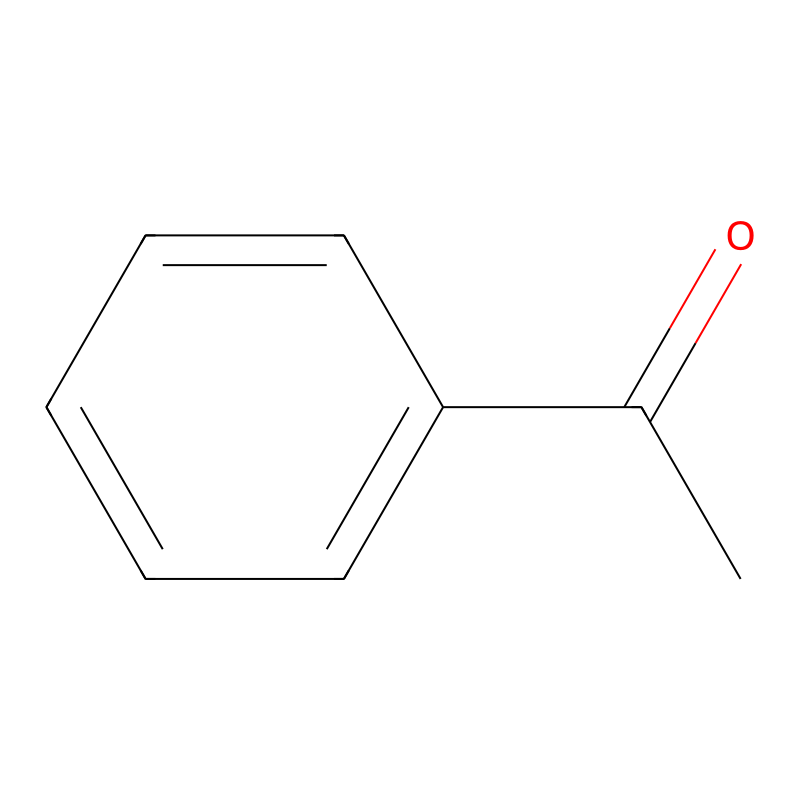

In [ ]:
from RetroChem.Package_functions.Interface_functions import render_molecule

img = render_molecule("CC(=O)c1ccccc1")  # acetophenone
if img:
    display(img)


<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

* **st_scaled_image(image, width_display_px=200)**

This function displays a PIL image inside a Streamlit app, scaled to a specific width.It converts the image to base64 and embeds it in HTML using st.markdown. 
This function is what allows for clean and responsive image rendering in a Streamlit app

Note: this function is optimized for the streamlit app so no example can be shown here. 

<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

Now that all molecules can be rendered, the next step is simply to display the full reaction: 

*  **render_reaction_scheme(smiles_chain)**

This function creates a horizontal visual scheme of a multi-step reaction or retrosynthesis pathway using molecule images rendered from SMILES strings. Each molecule is displayed as a base64-encoded image, joined by + (for combined reactants) and → (for stepwise progression).
1. Takes a list of lists called smiles_chain, where each inner list contains SMILES strings representing one reaction step's reactants or products.
2. Each SMILES string is:
- Parsed to an RDKit molecule,
- Rendered to a high-quality image using the mol_to_high_quality_imag function,
- Converted to a base64 HTML <img> tag using the image_to_base64 function.
3. Molecules in the same step are joined with " + " (e.g., multiple reactants) and steps are separated by "→" arrows.

As this function is also optimzed for the streamlit app, below is simply the rendering for the first prediction for the synthesis of acetonephenone as shown in the streamlit app.

<img src="../Images/ex_reaction_scheme.png" alt="visualization_prediction_pipeline" style="max-width: 100%; height: 200px; border: 1px solid black; margin: 5px;">

<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

# **Limitations**

Although RetroChem has very rapidly evolved over the past month, this has not come without its own limitations. The factors listed below each contribute to the overall performance of the program and more specifically each impose a certain limitation to RetroChem. 

1. **The database:**

The database chosen for this project consists of organic molecules featuring a majority of nitrogen and/or oxygen-based functional groups. This biases the model and limits its ability to accurately predict reaction templates for molecules containing other types of functional groups. Expanding the database could help address this limitation, but not without trade-offs. A larger dataset would increase the program’s runtime, and potentially reduce the model's accuracy due to increased complexity and class imbalance. Because the model's accuracy is already relatively low this is not yet a viable option.

2. **Model accuracy:**

As mentioned briefly above, the current model achieves an accuracy of approximately 18%, which is relatively low and leaves significant room for improvement. This low accuracy reduces the reliability of the proposed reactions and weakens the overall trustworthiness of the program. One major contributing factor is the limited number of input parameters used when predicting reaction templates. Currently, the model does not utilize any search algorithm and instead relies on an MLP (Multilayer Perceptron), a type of feedforward neural network. Incorporating a search algorithm (e.g., grid search or beam search) could improve prediction accuracy and enable the program to generate more plausible retrosynthetic routes. A specific search algorithm could potentially decrease the runtime and thus allow for a larger database to be chosen.




<div style="background-color: #f0efec; color: #14334a ; padding: 20px; border-radius: 20px; font-family: sans-serif; font-size: 14px">

# **What next ?**

With our app now able to predict retrosynthetic disconnections and visualize multi-step pathways, a meaningful next step is to extend its functionality by predicting reaction conditions, including solvents, catalysts, reagents, and temperatures for each transformation. This would bridge the gap between theoretical retrosynthesis and practical execution, turning our tool into a true reaction planning assistant.

There are two main directions we could explore:

1. **Developing a dedicated machine learning model for condition prediction:**

This would involve training a separate model using a dataset where reactions are annotated with experimental conditions. Public datasets such as USPTO Reaction Conditions, Reaxys, or Pistachio contain many examples with reagents, solvents, and temperature ranges. Features for this model could include molecular fingerprints (for reactants and products), reaction templates, atom mappings, or reaction class identifiers. A multi-label classification model could then predict likely sets of conditions for a given transformation. The advantage of this approach is that it could be fully integrated into the pipeline and run locally without external dependencies once trained.

2. **Integrating an AI language model (LLM) like ChatGPT via API:**

Alternatively, we could use an external LLM to generate reaction conditions by sending it a description or visual representation of each retrosynthetic step. The model would interpret the transformation and return a suggestion for suitable conditions (e.g., “DMSO, 60 °C, base catalyzed”). This method could leverage the LLM’s broad chemical knowledge and flexibility, particularly for uncommon transformations. However, it introduces additional complexity: users would need to obtain and configure their own OpenAI API key, and each request would consume API credits, which introduces a cost barrier.

Both approaches have their trade-offs. The ML model offers speed and privacy but may require considerable training data and engineering. The LLM based method is easier to prototype but depends on external services and user setup. A hybrid solution—starting with LLM integration for rapid prototyping and transitioning to a custom trained model could also be considered.